In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import AutoConfig
import torch
import torch.nn.functional as F

/share/kuleshov/emm392/conda/conda_envs/segment_nt/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
reverse_complement = False

In [3]:
sg_nt_cfg = AutoConfig.from_pretrained('InstaDeepAI/segment_nt_multi_species', trust_remote_code=True)

# Load Fwd Strand Annotations

In [4]:
segment_path = 'segment_nt/outputs/agg_30kb_multi_species.npy' 
base_probs = np.load(segment_path)

# Load Rev Strand Annotations

In [15]:
rc_segment_path = 'segment_nt/outputs/agg_30kb_multi_species_rc_3to5.npy' 
#rc_segment_path = 'segment_nt/outputs/agg_30kb_multi_species_rev_strand_comp.npy'
rc_base_probs = np.load(rc_segment_path)

In [6]:
base_probs.shape 

(64444167, 14)

## Get Annotations
Get the annotations in order from the model config.
Hard code them in case a future revision changes the order compared to the model used to initiall generate the probabities.

In [10]:
annotations = sg_nt_cfg.features


In [8]:
hard_coded_annotations = ['protein_coding_gene',
 'lncRNA',
 'exon',
 'intron',
 'splice_donor',
 'splice_acceptor',
 '5UTR',
 '3UTR',
 'CTCF-bound',
 'polyA_signal',
 'enhancer_Tissue_specific',
 'enhancer_Tissue_invariant',
 'promoter_Tissue_specific',
 'promoter_Tissue_invariant']

In [9]:
for idx, (cfg_annot, hrd_annot) in enumerate(zip(annotations, hard_coded_annotations)):
    assert cfg_annot == hrd_annot, f"Annotation order did not match, got {cfg_annot} and {hrd_annot} at index {idx} "

In [ ]:
def kernel_filter(x, mean_thresh, max_thresh):
    """
    Return a filtered version of x
    If mean(x) < mean_thresh return 0
    if max(x) < max_thresh return 0
    """
    num_bps, num_annotations = x.shape
    annot_means = np.mean(x, axis=0)
    annot_maxs = np.max(x, axis=0)
    tmp = np.zeros_like(x)
    for annot_idx in range(num_annotations):
        annot_mean = annot_means[annot_idx]
        annot_max = annot_maxs[annot_idx]
        if annot_mean < mean_thresh:
            tmp[:,annot_idx]=0
        elif annot_max < max_thresh:
            tmp[:, annot_idx] = 0
        else:
            tmp[:, annot_idx] = x[:, annot_idx]
    return tmp
    

In [9]:
num_nnz_bps = (base_probs.sum(axis=1)>0).sum()
print(f"{num_nnz_bps} bps with a non-zero annotation. {num_nnz_bps/base_probs.shape[0] * 100}%")

62520000 bps with a non-zero annotation. 97.01421076635222%


In [147]:
window_len = 20
stride = 0
seq_len = base_probs.shape[0]
mean_thresh = 0.1
max_thresh = 0.5
for window_idx in tqdm(range(0, seq_len, window_len-stride)):
    window = base_probs[window_idx:window_idx + window_len,:]
    base_probs[window_idx:window_idx+window_len] = kernel_filter(window, mean_thresh=mean_thresh, max_thresh=max_thresh)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3222209/3222209 [03:30<00:00, 15321.66it/s]


In [10]:
num_nnz_bps = (base_probs.sum(axis=1)>0).sum()
print(f"After Pre-filtering: {num_nnz_bps} bps with a non-zero annotation. {num_nnz_bps/base_probs.shape[0] * 100}%")

After Pre-filtering: 62520000 bps with a non-zero annotation. 97.01421076635222%


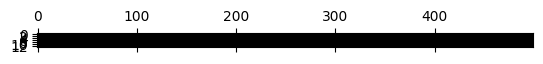

In [9]:
idx = 2650520
plt.spy(base_probs[idx+3500:idx+4000].T)

In [10]:
(base_probs>0).argmax()

1050000

In [11]:
(base_probs>0).sum()

875280000

In [12]:
base_probs[idx+3500:idx+4000]

array([[0.99341172, 0.01696604, 0.02069165, ..., 0.01398661, 0.01256971,
        0.00175746],
       [0.99351007, 0.01799094, 0.02198432, ..., 0.01344461, 0.01298929,
        0.00139496],
       [0.99304056, 0.02043123, 0.02304903, ..., 0.014376  , 0.01068991,
        0.00148077],
       ...,
       [0.99342209, 0.03161765, 0.98798031, ..., 0.01165842, 0.04095458,
        0.01533263],
       [0.99295008, 0.03433412, 0.98747706, ..., 0.00916274, 0.04350919,
        0.01538423],
       [0.99230325, 0.03051627, 0.98873478, ..., 0.00947108, 0.04640734,
        0.01799523]])

## Load RNAseq data
Load the auxiliarry RNAseq data

In [11]:
rna_seq_path = os.path.join('rnaseq_data', 'splice_site_usage_rnaseq-heart.txt')
splice_counts = pd.read_csv(rna_seq_path, index_col=None, sep='\t', names=['chromosome', 'strand', 'position', 'type', 'count'])
splice_counts.head()

,chromosome,strand,position,type,count
0,chr20,+,142686,donor,0
1,chr20,+,143040,donor,0
2,chr20,+,145415,acceptor,0
3,chr20,+,145488,donor,0
4,chr20,+,145579,acceptor,0


In [36]:
splice_counts['fwd_donor_prob'] = base_probs[splice_counts['position'], annotations.index('splice_donor')]
splice_counts['fwd_acceptor_prob'] = base_probs[splice_counts['position'], annotations.index('splice_acceptor')]
splice_counts['rev_donor_prob'] = rc_base_probs[splice_counts['position'], annotations.index('splice_donor')]
splice_counts['rev_acceptor_prob'] = rc_base_probs[splice_counts['position'], annotations.index('splice_acceptor')]

In [38]:
splice_counts[splice_counts['count'] > 10]

,chromosome,strand,position,type,count,fwd_donor_prob,fwd_acceptor_prob,rev_donor_prob,rev_acceptor_prob
8,chr20,+,347142,acceptor,210,0.288902,0.006163,0.006556,0.000565
9,chr20,+,347142,donor,25,0.288902,0.006163,0.006556,0.000565
10,chr20,+,347434,acceptor,25,0.014037,0.011499,0.012428,0.025940
12,chr20,+,347512,acceptor,24,0.014103,0.004819,0.012423,0.011218
14,chr20,+,348063,acceptor,55,0.179504,0.004647,0.032225,0.004950
...,...,...,...,...,...,...,...,...,...
10889,chr20,-,64076857,acceptor,130,0.151612,0.005487,0.083808,0.001961
10890,chr20,-,64076954,donor,33,0.008220,0.439070,0.007251,0.133543
10891,chr20,-,64079294,acceptor,22,0.086487,0.010445,0.053842,0.005045
10892,chr20,-,64079294,donor,23,0.086487,0.010445,0.053842,0.005045


## Plot the annotations

In [39]:
idx = 2658520 #2650520
window_size = 5000

In [40]:
rc_base_probs = rc_base_probs[::-1,:]

<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_3149530/2050280942.py:13: SyntaxWarning: invalid escape sequence '\D'
  axes[2].set_ylabel('Probability $\Delta$')


Text(0.5, 0, 'Position (bp)')

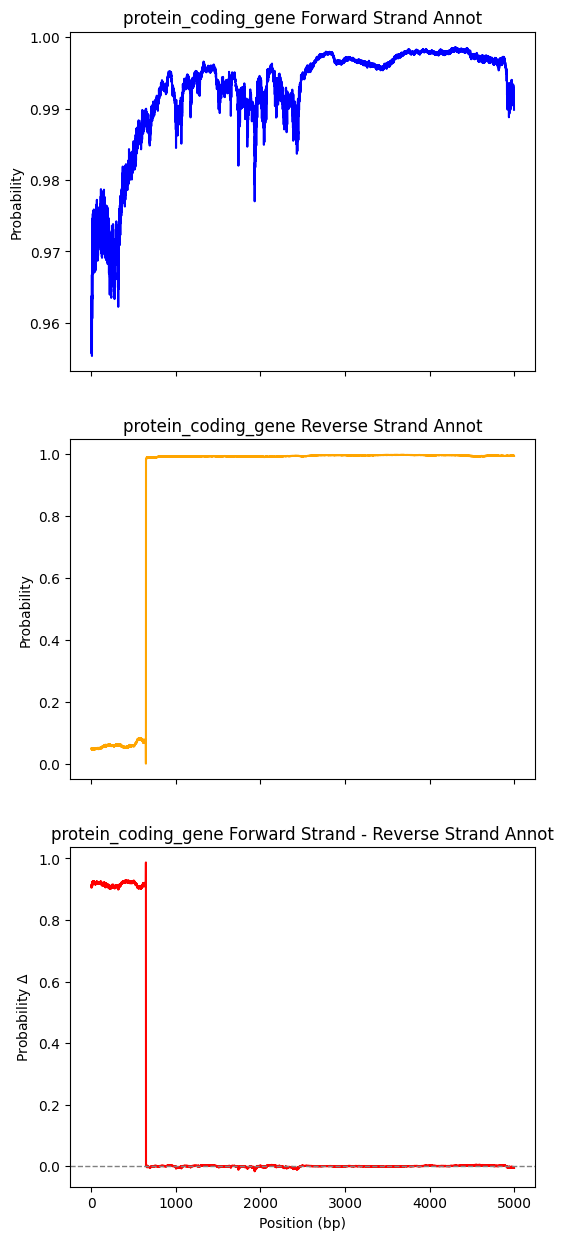

In [41]:
annot_idx = 0
fig, axes = plt.subplots(3, 1, figsize=(6, 15), sharex=True)  # 3 rows, 1 column

axes[0].plot(np.arange(window_size), base_probs[idx:idx+window_size,annot_idx], label='+ strand', color='blue')
axes[0].set_title(f'{annotations[annot_idx]} Forward Strand Annot')
axes[0].set_ylabel('Probability')
axes[1].plot(np.arange(window_size), rc_base_probs[idx:idx+window_size,annot_idx], label='- strand', color='orange')
axes[1].set_title(f'{annotations[annot_idx]} Reverse Strand Annot')
axes[1].set_ylabel('Probability')
axes[2].plot(np.arange(window_size), base_probs[idx:idx+window_size,annot_idx] - rc_base_probs[idx:idx+window_size,annot_idx], label='fwd - rev', color='red')
axes[2].axhline(y=0, color='gray', linestyle='--', linewidth=1, label='y=0')  # Dashed horizontal line
axes[2].set_title(f'{annotations[annot_idx]} Forward Strand - Reverse Strand Annot')
axes[2].set_ylabel('Probability $\Delta$')
axes[2].set_xlabel('Position (bp)')
#plt.legend()
#plt.title(f'{annotations[annot_idx]}')

<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_3149530/2018193501.py:13: SyntaxWarning: invalid escape sequence '\D'
  axes[2].set_ylabel('Probability $\Delta$')


Text(0.5, 0, 'Position (bp)')

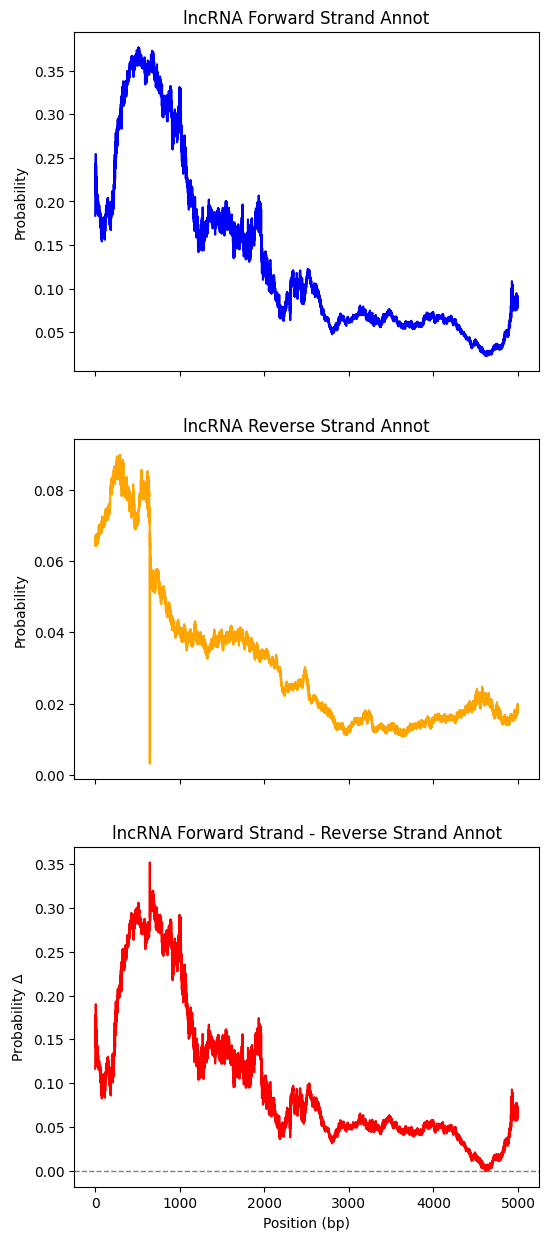

In [42]:
annot_idx = 1
fig, axes = plt.subplots(3, 1, figsize=(6, 15), sharex=True)  # 3 rows, 1 column

axes[0].plot(np.arange(window_size), base_probs[idx:idx+window_size,annot_idx], label='+ strand', color='blue')
axes[0].set_title(f'{annotations[annot_idx]} Forward Strand Annot')
axes[0].set_ylabel('Probability')
axes[1].plot(np.arange(window_size), rc_base_probs[idx:idx+window_size,annot_idx], label='- strand', color='orange')
axes[1].set_title(f'{annotations[annot_idx]} Reverse Strand Annot')
axes[1].set_ylabel('Probability')
axes[2].plot(np.arange(window_size), base_probs[idx:idx+window_size,annot_idx] - rc_base_probs[idx:idx+window_size,annot_idx], label='fwd - rev', color='red')
axes[2].axhline(y=0, color='gray', linestyle='--', linewidth=1, label='y=0')  # Dashed horizontal line
axes[2].set_title(f'{annotations[annot_idx]} Forward Strand - Reverse Strand Annot')
axes[2].set_ylabel('Probability $\Delta$')
axes[2].set_xlabel('Position (bp)')


<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_3149530/3530467058.py:13: SyntaxWarning: invalid escape sequence '\D'
  axes[2].set_ylabel('Probability $\Delta$')


Text(0.5, 0, 'Position (bp)')

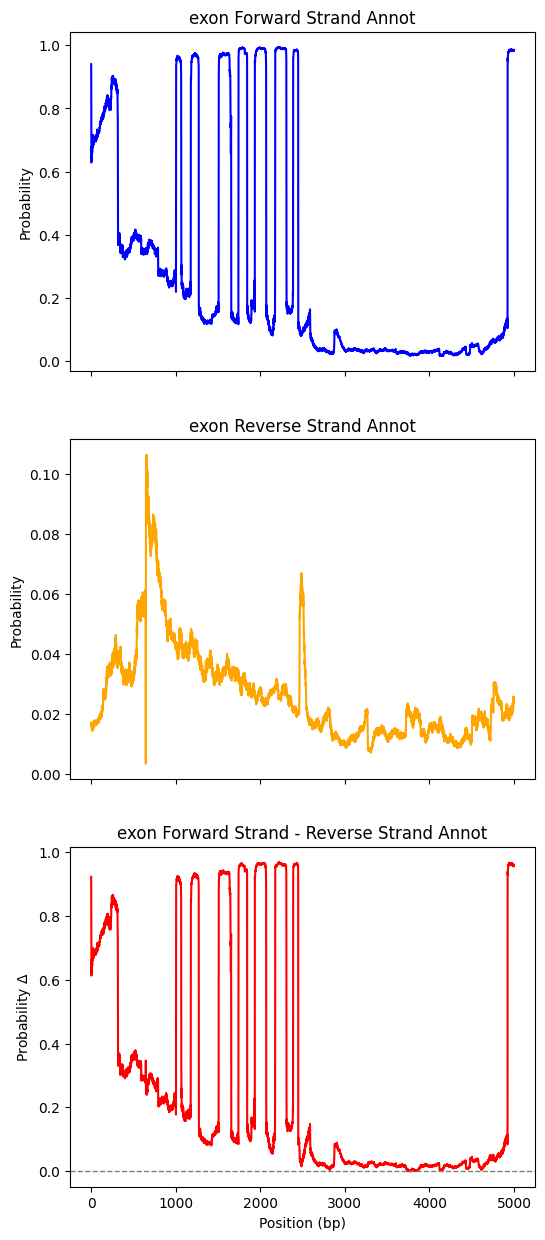

In [43]:
annot_idx = 2
fig, axes = plt.subplots(3, 1, figsize=(6, 15), sharex=True)  # 3 rows, 1 column

axes[0].plot(np.arange(window_size), base_probs[idx:idx+window_size,annot_idx], label='+ strand', color='blue')
axes[0].set_title(f'{annotations[annot_idx]} Forward Strand Annot')
axes[0].set_ylabel('Probability')
axes[1].plot(np.arange(window_size), rc_base_probs[idx:idx+window_size,annot_idx], label='- strand', color='orange')
axes[1].set_title(f'{annotations[annot_idx]} Reverse Strand Annot')
axes[1].set_ylabel('Probability')
axes[2].plot(np.arange(window_size), base_probs[idx:idx+window_size,annot_idx] - rc_base_probs[idx:idx+window_size,annot_idx], label='fwd - rev', color='red')
axes[2].axhline(y=0, color='gray', linestyle='--', linewidth=1, label='y=0')  # Dashed horizontal line
axes[2].set_title(f'{annotations[annot_idx]} Forward Strand - Reverse Strand Annot')
axes[2].set_ylabel('Probability $\Delta$')
axes[2].set_xlabel('Position (bp)')

<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_3149530/3029097192.py:13: SyntaxWarning: invalid escape sequence '\D'
  axes[2].set_ylabel('Probability $\Delta$')


Text(0.5, 0, 'Position (bp)')

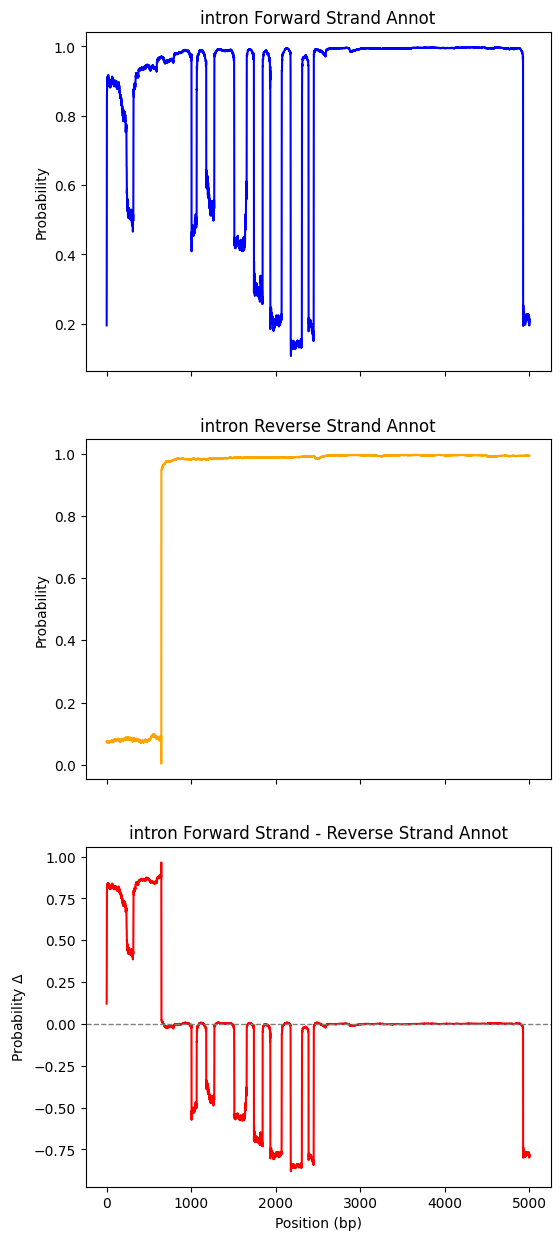

In [44]:
annot_idx = 3
fig, axes = plt.subplots(3, 1, figsize=(6, 15), sharex=True)  # 3 rows, 1 column

axes[0].plot(np.arange(window_size), base_probs[idx:idx+window_size,annot_idx], label='+ strand', color='blue')
axes[0].set_title(f'{annotations[annot_idx]} Forward Strand Annot')
axes[0].set_ylabel('Probability')
axes[1].plot(np.arange(window_size), rc_base_probs[idx:idx+window_size,annot_idx], label='- strand', color='orange')
axes[1].set_title(f'{annotations[annot_idx]} Reverse Strand Annot')
axes[1].set_ylabel('Probability')
axes[2].plot(np.arange(window_size), base_probs[idx:idx+window_size,annot_idx] - rc_base_probs[idx:idx+window_size,annot_idx], label='fwd - rev', color='red')
axes[2].axhline(y=0, color='gray', linestyle='--', linewidth=1, label='y=0')  # Dashed horizontal line
axes[2].set_title(f'{annotations[annot_idx]} Forward Strand - Reverse Strand Annot')
axes[2].set_ylabel('Probability $\Delta$')
axes[2].set_xlabel('Position (bp)')

<>:33: SyntaxWarning: invalid escape sequence '\D'
<>:33: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_3149530/2115349539.py:33: SyntaxWarning: invalid escape sequence '\D'
  axes[4].set_ylabel('Probability $\Delta$')


Text(0.5, 0, 'Position (bp)')

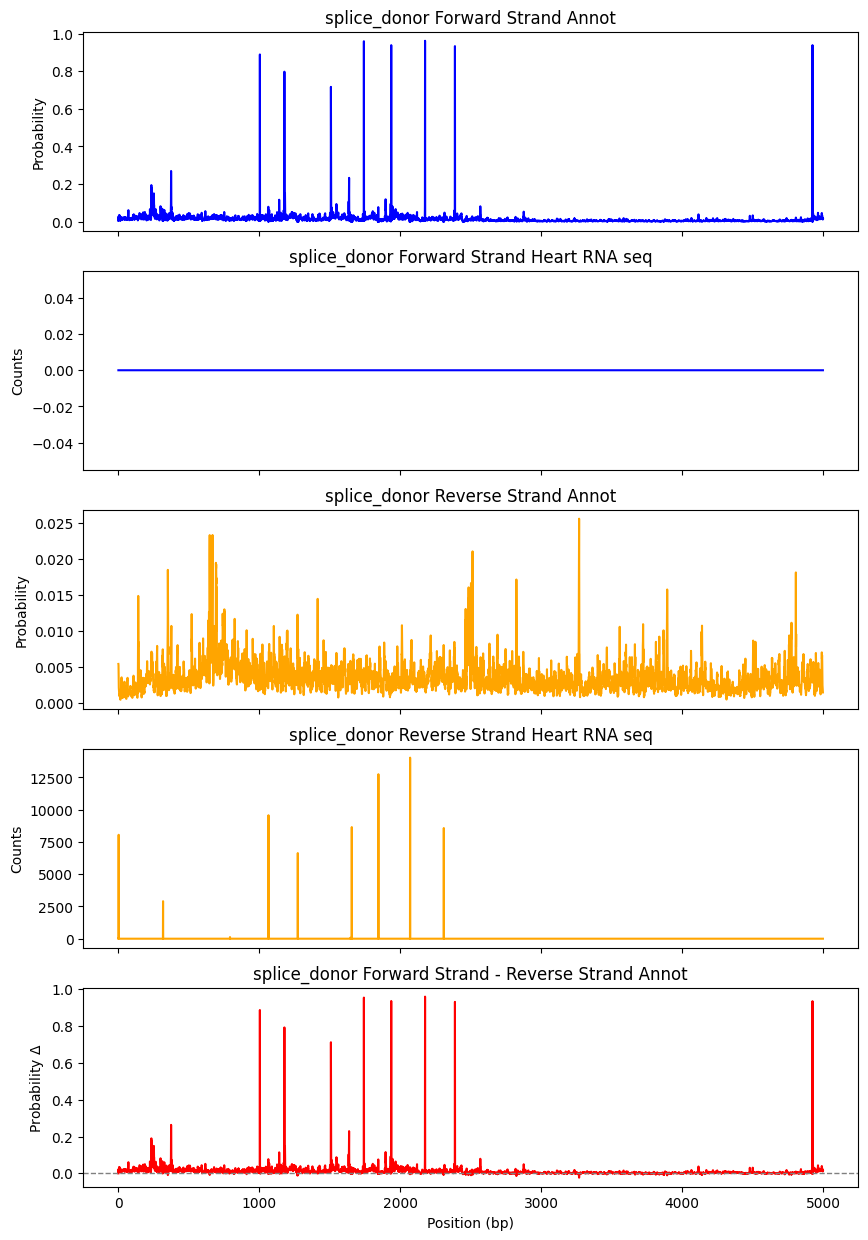

In [45]:
annot_idx = 4
fig, axes = plt.subplots(5, 1, figsize=(10, 15), sharex=True)  # 5 rows, 1 column

axes[0].plot(np.arange(window_size), base_probs[idx:idx+window_size,annot_idx], label='+ strand', color='blue')
axes[0].set_title(f'{annotations[annot_idx]} Forward Strand Annot')
axes[0].set_ylabel('Probability')

forward_counts = splice_counts.loc[(splice_counts['position'] > idx) & (splice_counts['position'] <= idx + window_size) & (splice_counts['type'] == 'donor')& (splice_counts['strand'] == '+')]
counts = np.zeros(window_size)
for row_idx, row in forward_counts.iterrows():
    counts[row['position'] - idx] = row['count']
axes[1].plot(np.arange(window_size), counts, label='+ strand RNAseq', color='blue')
axes[1].set_title(f'{annotations[annot_idx]} Forward Strand Heart RNA seq')
axes[1].set_ylabel('Counts')

axes[2].plot(np.arange(window_size), rc_base_probs[idx:idx+window_size,annot_idx], label='- strand', color='orange')
axes[2].set_title(f'{annotations[annot_idx]} Reverse Strand Annot')
axes[2].set_ylabel('Probability')

reverse_counts = splice_counts.loc[(splice_counts['position'] > idx) & (splice_counts['position'] <= idx + window_size) & (splice_counts['type'] == 'donor') & (splice_counts['strand'] == '-')]
counts = np.zeros(window_size)
for row_idx, row in reverse_counts.iterrows():
    counts[row['position'] - idx] = row['count']
axes[3].plot(np.arange(window_size), counts, label='- strand RNAseq', color='orange')
axes[3].set_title(f'{annotations[annot_idx]} Reverse Strand Heart RNA seq')
axes[3].set_ylabel('Counts')



axes[4].plot(np.arange(window_size), base_probs[idx:idx+window_size,annot_idx] - rc_base_probs[idx:idx+window_size,annot_idx], label='fwd - rev', color='red')
axes[4].axhline(y=0, color='gray', linestyle='--', linewidth=1, label='y=0')  # Dashed horizontal line
axes[4].set_title(f'{annotations[annot_idx]} Forward Strand - Reverse Strand Annot')
axes[4].set_ylabel('Probability $\Delta$')
axes[4].set_xlabel('Position (bp)')

<>:33: SyntaxWarning: invalid escape sequence '\D'
<>:33: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_3149530/3010192700.py:33: SyntaxWarning: invalid escape sequence '\D'
  axes[4].set_ylabel('Probability $\Delta$')


Text(0.5, 0, 'Position (bp)')

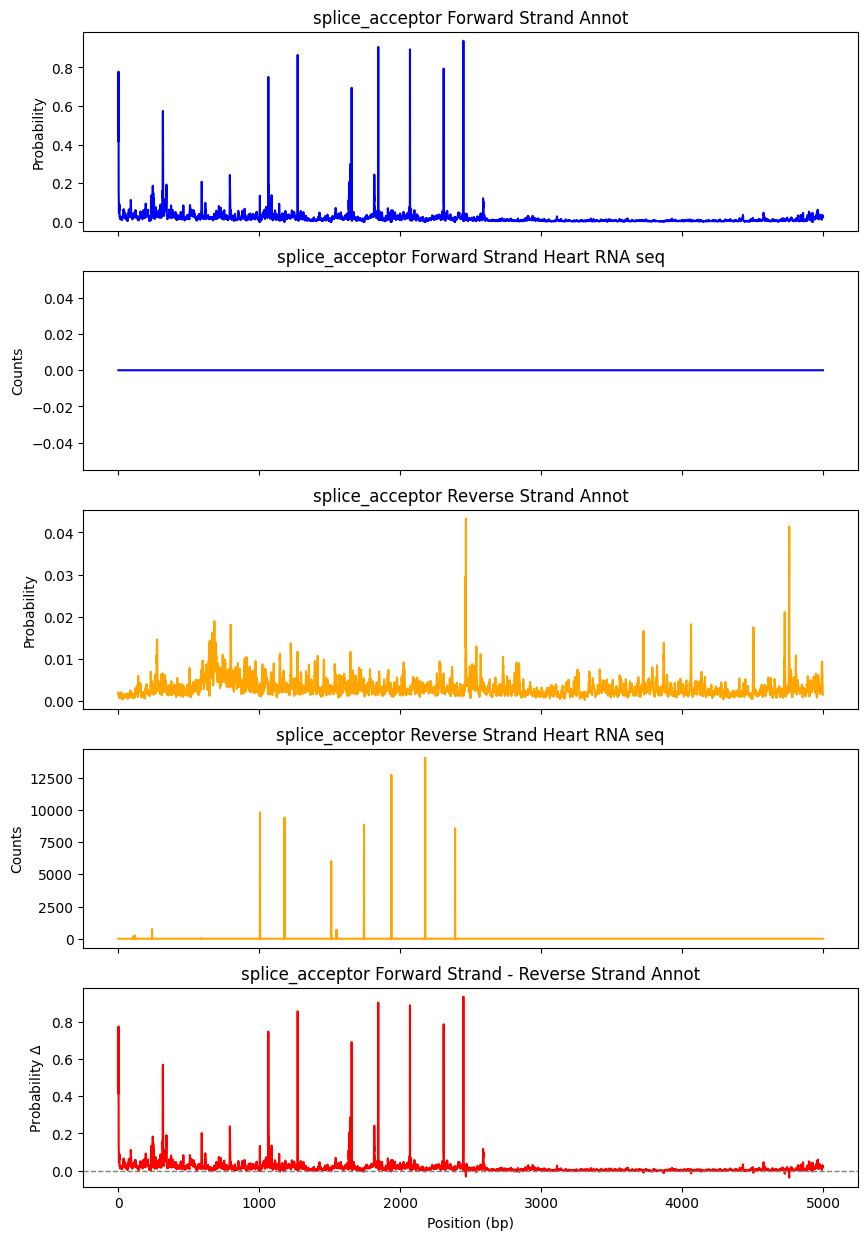

In [46]:
annot_idx = 5
fig, axes = plt.subplots(5, 1, figsize=(10, 15), sharex=True)  # 5 rows, 1 column

axes[0].plot(np.arange(window_size), base_probs[idx:idx+window_size,annot_idx], label='+ strand', color='blue')
axes[0].set_title(f'{annotations[annot_idx]} Forward Strand Annot')
axes[0].set_ylabel('Probability')

forward_counts = splice_counts.loc[(splice_counts['position'] > idx) & (splice_counts['position'] <= idx + window_size) & (splice_counts['type'] == 'acceptor')& (splice_counts['strand'] == '+')]
counts = np.zeros(window_size)
for row_idx, row in forward_counts.iterrows():
    counts[row['position'] - idx] = row['count']
axes[1].plot(np.arange(window_size), counts, label='+ strand RNAseq', color='blue')
axes[1].set_title(f'{annotations[annot_idx]} Forward Strand Heart RNA seq')
axes[1].set_ylabel('Counts')

axes[2].plot(np.arange(window_size), rc_base_probs[idx:idx+window_size,annot_idx], label='- strand', color='orange')
axes[2].set_title(f'{annotations[annot_idx]} Reverse Strand Annot')
axes[2].set_ylabel('Probability')

reverse_counts = splice_counts.loc[(splice_counts['position'] > idx) & (splice_counts['position'] <= idx + window_size) & (splice_counts['type'] == 'acceptor') & (splice_counts['strand'] == '-')]
counts = np.zeros(window_size)
for row_idx, row in reverse_counts.iterrows():
    counts[row['position'] - idx] = row['count']
axes[3].plot(np.arange(window_size), counts, label='- strand RNAseq', color='orange')
axes[3].set_title(f'{annotations[annot_idx]} Reverse Strand Heart RNA seq')
axes[3].set_ylabel('Counts')



axes[4].plot(np.arange(window_size), base_probs[idx:idx+window_size,annot_idx] - rc_base_probs[idx:idx+window_size,annot_idx], label='fwd - rev', color='red')
axes[4].axhline(y=0, color='gray', linestyle='--', linewidth=1, label='y=0')  # Dashed horizontal line
axes[4].set_title(f'{annotations[annot_idx]} Forward Strand - Reverse Strand Annot')
axes[4].set_ylabel('Probability $\Delta$')
axes[4].set_xlabel('Position (bp)')

<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_3149530/251572105.py:13: SyntaxWarning: invalid escape sequence '\D'
  axes[2].set_ylabel('Probability $\Delta$')


Text(0.5, 0, 'Position (bp)')

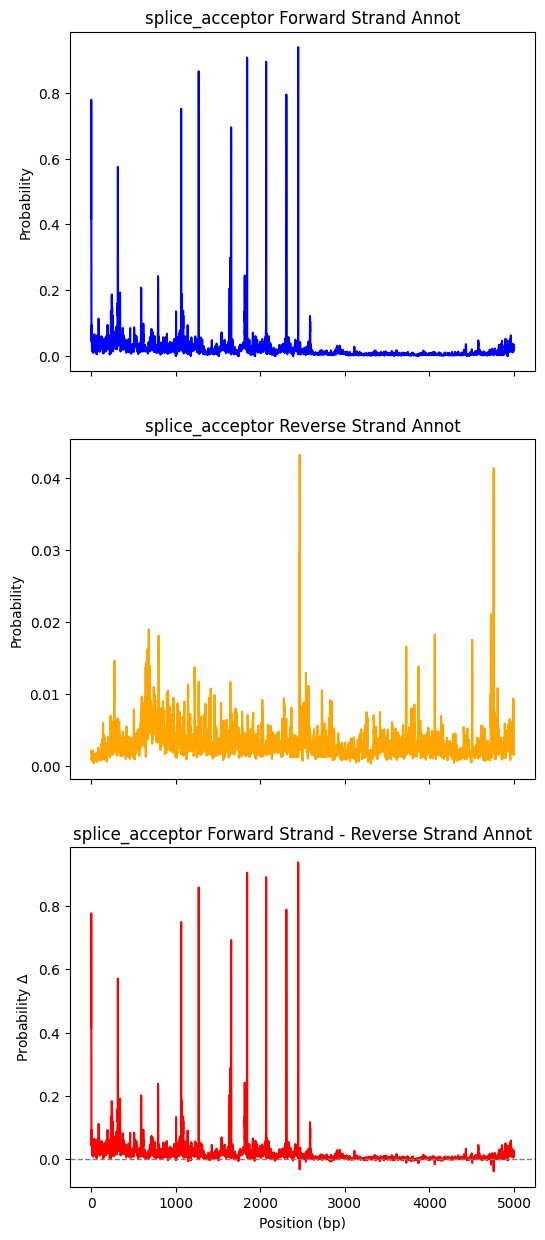

In [47]:
annot_idx = 5
fig, axes = plt.subplots(3, 1, figsize=(6, 15), sharex=True)  # 3 rows, 1 column

axes[0].plot(np.arange(window_size), base_probs[idx:idx+window_size,annot_idx], label='+ strand', color='blue')
axes[0].set_title(f'{annotations[annot_idx]} Forward Strand Annot')
axes[0].set_ylabel('Probability')
axes[1].plot(np.arange(window_size), rc_base_probs[idx:idx+window_size,annot_idx], label='- strand', color='orange')
axes[1].set_title(f'{annotations[annot_idx]} Reverse Strand Annot')
axes[1].set_ylabel('Probability')
axes[2].plot(np.arange(window_size), base_probs[idx:idx+window_size,annot_idx] - rc_base_probs[idx:idx+window_size,annot_idx], label='fwd - rev', color='red')
axes[2].axhline(y=0, color='gray', linestyle='--', linewidth=1, label='y=0')  # Dashed horizontal line
axes[2].set_title(f'{annotations[annot_idx]} Forward Strand - Reverse Strand Annot')
axes[2].set_ylabel('Probability $\Delta$')
axes[2].set_xlabel('Position (bp)')

<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_3149530/3473089619.py:13: SyntaxWarning: invalid escape sequence '\D'
  axes[2].set_ylabel('Probability $\Delta$')


Text(0.5, 0, 'Position (bp)')

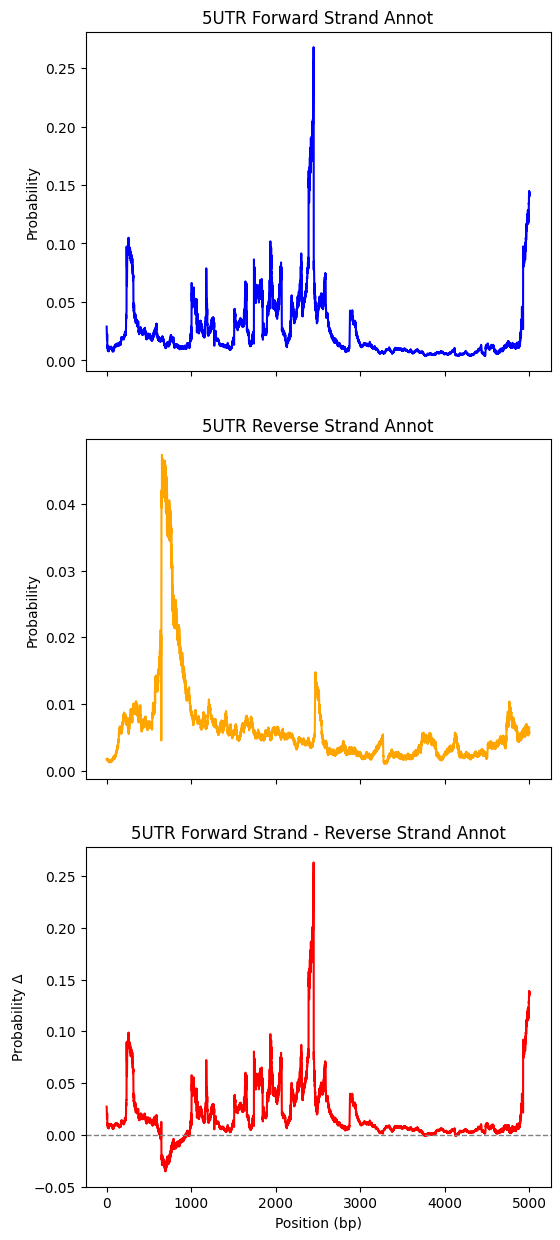

In [48]:
annot_idx = 6
fig, axes = plt.subplots(3, 1, figsize=(6, 15), sharex=True)  # 3 rows, 1 column

axes[0].plot(np.arange(window_size), base_probs[idx:idx+window_size,annot_idx], label='+ strand', color='blue')
axes[0].set_title(f'{annotations[annot_idx]} Forward Strand Annot')
axes[0].set_ylabel('Probability')
axes[1].plot(np.arange(window_size), rc_base_probs[idx:idx+window_size,annot_idx], label='- strand', color='orange')
axes[1].set_title(f'{annotations[annot_idx]} Reverse Strand Annot')
axes[1].set_ylabel('Probability')
axes[2].plot(np.arange(window_size), base_probs[idx:idx+window_size,annot_idx] - rc_base_probs[idx:idx+window_size,annot_idx], label='fwd - rev', color='red')
axes[2].axhline(y=0, color='gray', linestyle='--', linewidth=1, label='y=0')  # Dashed horizontal line
axes[2].set_title(f'{annotations[annot_idx]} Forward Strand - Reverse Strand Annot')
axes[2].set_ylabel('Probability $\Delta$')
axes[2].set_xlabel('Position (bp)')

<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_3136185/1091207455.py:13: SyntaxWarning: invalid escape sequence '\D'
  axes[2].set_ylabel('Probability $\Delta$')


Text(0.5, 0, 'Position (bp)')

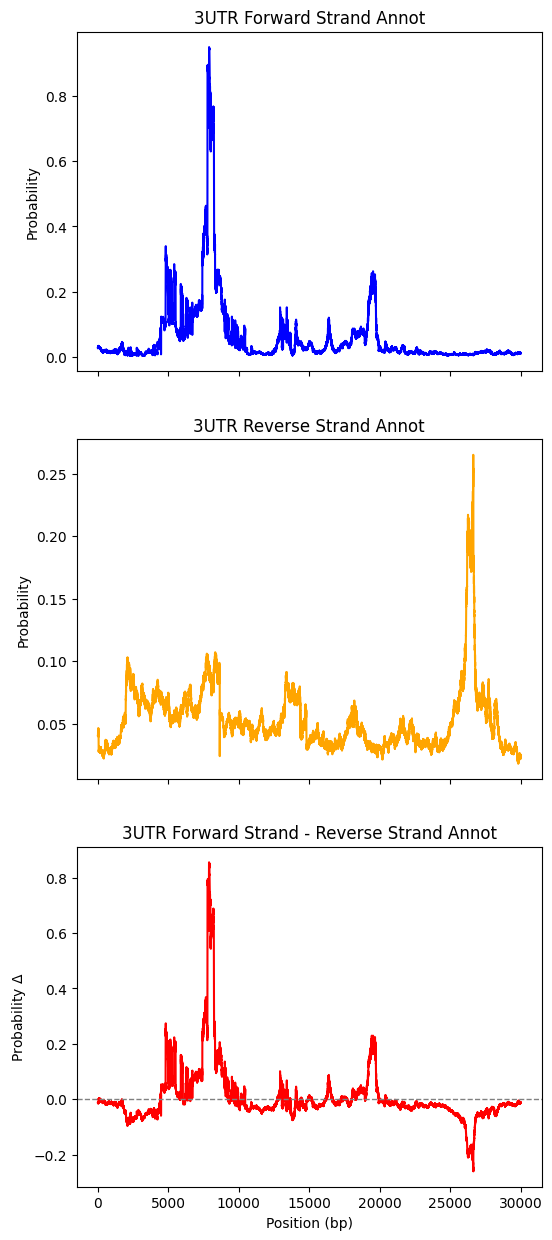

In [20]:
annot_idx = 7
fig, axes = plt.subplots(3, 1, figsize=(6, 15), sharex=True)  # 3 rows, 1 column

axes[0].plot(np.arange(window_size), base_probs[idx:idx+window_size,annot_idx], label='+ strand', color='blue')
axes[0].set_title(f'{annotations[annot_idx]} Forward Strand Annot')
axes[0].set_ylabel('Probability')
axes[1].plot(np.arange(window_size), rc_base_probs[idx:idx+window_size,annot_idx], label='- strand', color='orange')
axes[1].set_title(f'{annotations[annot_idx]} Reverse Strand Annot')
axes[1].set_ylabel('Probability')
axes[2].plot(np.arange(window_size), base_probs[idx:idx+window_size,annot_idx] - rc_base_probs[idx:idx+window_size,annot_idx], label='fwd - rev', color='red')
axes[2].axhline(y=0, color='gray', linestyle='--', linewidth=1, label='y=0')  # Dashed horizontal line
axes[2].set_title(f'{annotations[annot_idx]} Forward Strand - Reverse Strand Annot')
axes[2].set_ylabel('Probability $\Delta$')
axes[2].set_xlabel('Position (bp)')

<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_3136185/1886217497.py:13: SyntaxWarning: invalid escape sequence '\D'
  axes[2].set_ylabel('Probability $\Delta$')


Text(0.5, 0, 'Position (bp)')

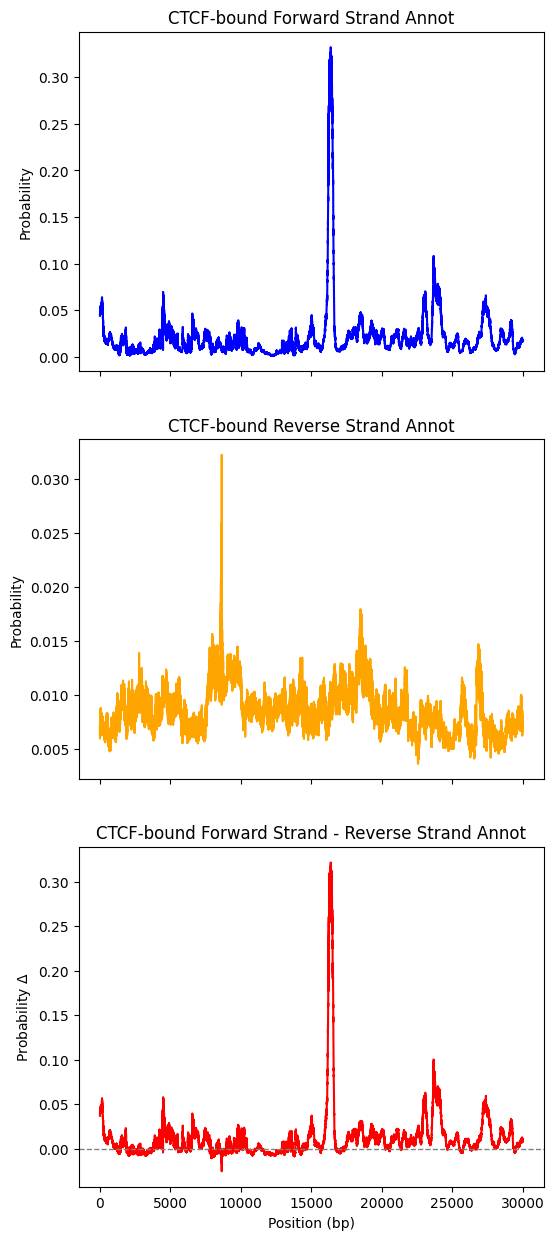

In [21]:
annot_idx = 8
fig, axes = plt.subplots(3, 1, figsize=(6, 15), sharex=True)  # 3 rows, 1 column

axes[0].plot(np.arange(window_size), base_probs[idx:idx+window_size,annot_idx], label='+ strand', color='blue')
axes[0].set_title(f'{annotations[annot_idx]} Forward Strand Annot')
axes[0].set_ylabel('Probability')
axes[1].plot(np.arange(window_size), rc_base_probs[idx:idx+window_size,annot_idx], label='- strand', color='orange')
axes[1].set_title(f'{annotations[annot_idx]} Reverse Strand Annot')
axes[1].set_ylabel('Probability')
axes[2].plot(np.arange(window_size), base_probs[idx:idx+window_size,annot_idx] - rc_base_probs[idx:idx+window_size,annot_idx], label='fwd - rev', color='red')
axes[2].axhline(y=0, color='gray', linestyle='--', linewidth=1, label='y=0')  # Dashed horizontal line
axes[2].set_title(f'{annotations[annot_idx]} Forward Strand - Reverse Strand Annot')
axes[2].set_ylabel('Probability $\Delta$')
axes[2].set_xlabel('Position (bp)')

<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_3136185/1928261047.py:13: SyntaxWarning: invalid escape sequence '\D'
  axes[2].set_ylabel('Probability $\Delta$')


Text(0.5, 0, 'Position (bp)')

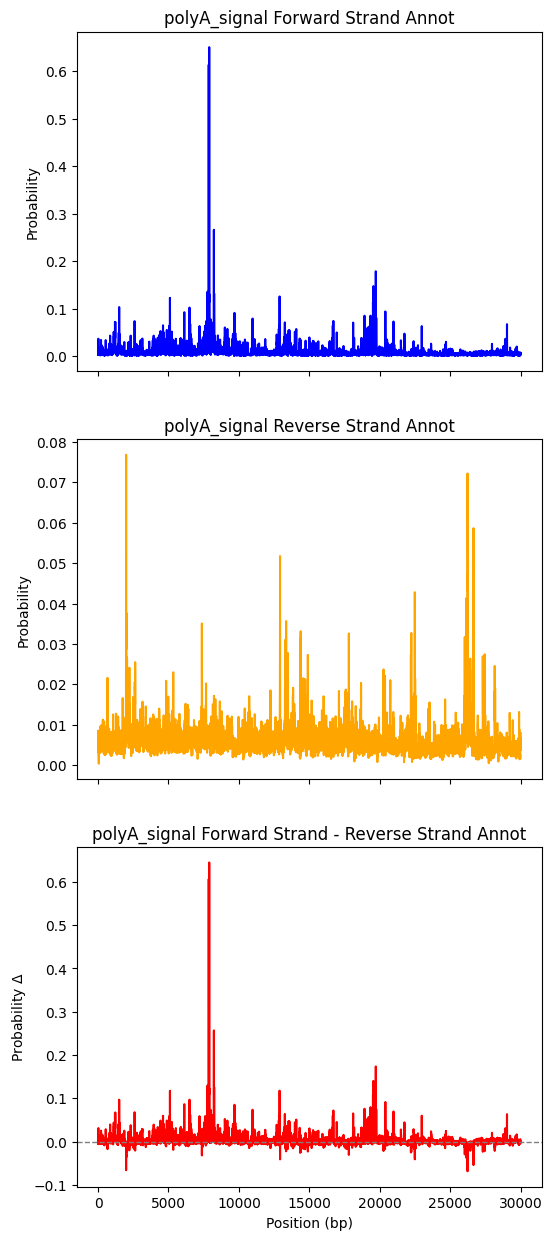

In [22]:
annot_idx = 9
fig, axes = plt.subplots(3, 1, figsize=(6, 15), sharex=True)  # 3 rows, 1 column

axes[0].plot(np.arange(window_size), base_probs[idx:idx+window_size,annot_idx], label='+ strand', color='blue')
axes[0].set_title(f'{annotations[annot_idx]} Forward Strand Annot')
axes[0].set_ylabel('Probability')
axes[1].plot(np.arange(window_size), rc_base_probs[idx:idx+window_size,annot_idx], label='- strand', color='orange')
axes[1].set_title(f'{annotations[annot_idx]} Reverse Strand Annot')
axes[1].set_ylabel('Probability')
axes[2].plot(np.arange(window_size), base_probs[idx:idx+window_size,annot_idx] - rc_base_probs[idx:idx+window_size,annot_idx], label='fwd - rev', color='red')
axes[2].axhline(y=0, color='gray', linestyle='--', linewidth=1, label='y=0')  # Dashed horizontal line
axes[2].set_title(f'{annotations[annot_idx]} Forward Strand - Reverse Strand Annot')
axes[2].set_ylabel('Probability $\Delta$')
axes[2].set_xlabel('Position (bp)')

<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_3136185/2976401174.py:13: SyntaxWarning: invalid escape sequence '\D'
  axes[2].set_ylabel('Probability $\Delta$')


Text(0.5, 0, 'Position (bp)')

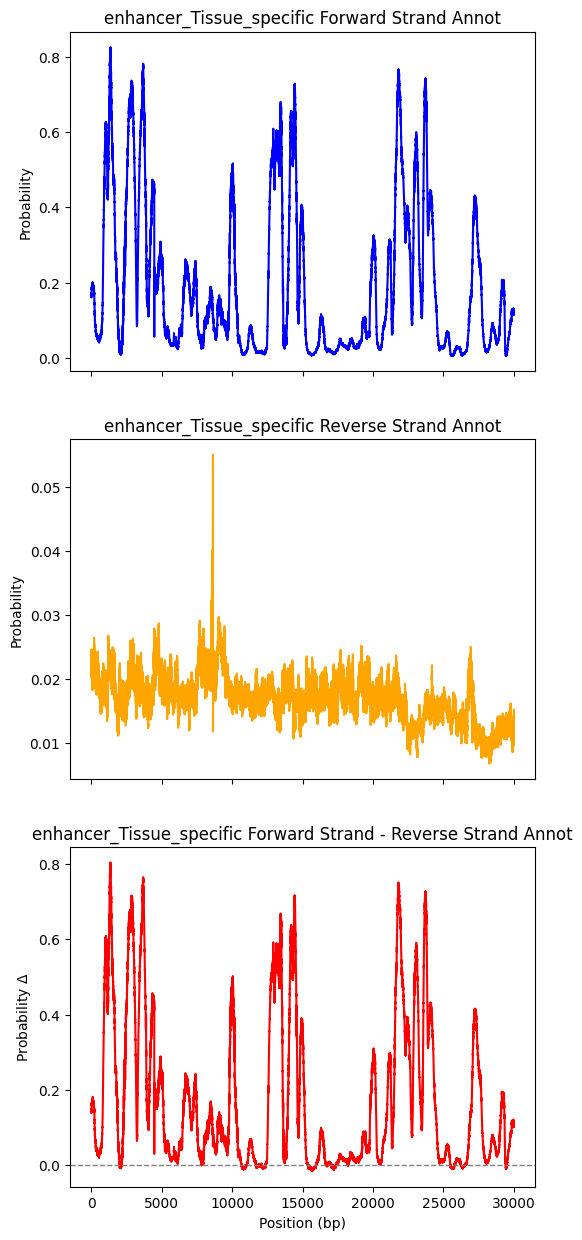

In [23]:
annot_idx = 10
fig, axes = plt.subplots(3, 1, figsize=(6, 15), sharex=True)  # 3 rows, 1 column

axes[0].plot(np.arange(window_size), base_probs[idx:idx+window_size,annot_idx], label='+ strand', color='blue')
axes[0].set_title(f'{annotations[annot_idx]} Forward Strand Annot')
axes[0].set_ylabel('Probability')
axes[1].plot(np.arange(window_size), rc_base_probs[idx:idx+window_size,annot_idx], label='- strand', color='orange')
axes[1].set_title(f'{annotations[annot_idx]} Reverse Strand Annot')
axes[1].set_ylabel('Probability')
axes[2].plot(np.arange(window_size), base_probs[idx:idx+window_size,annot_idx] - rc_base_probs[idx:idx+window_size,annot_idx], label='fwd - rev', color='red')
axes[2].axhline(y=0, color='gray', linestyle='--', linewidth=1, label='y=0')  # Dashed horizontal line
axes[2].set_title(f'{annotations[annot_idx]} Forward Strand - Reverse Strand Annot')
axes[2].set_ylabel('Probability $\Delta$')
axes[2].set_xlabel('Position (bp)')

<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_3136185/1059841114.py:13: SyntaxWarning: invalid escape sequence '\D'
  axes[2].set_ylabel('Probability $\Delta$')


Text(0.5, 0, 'Position (bp)')

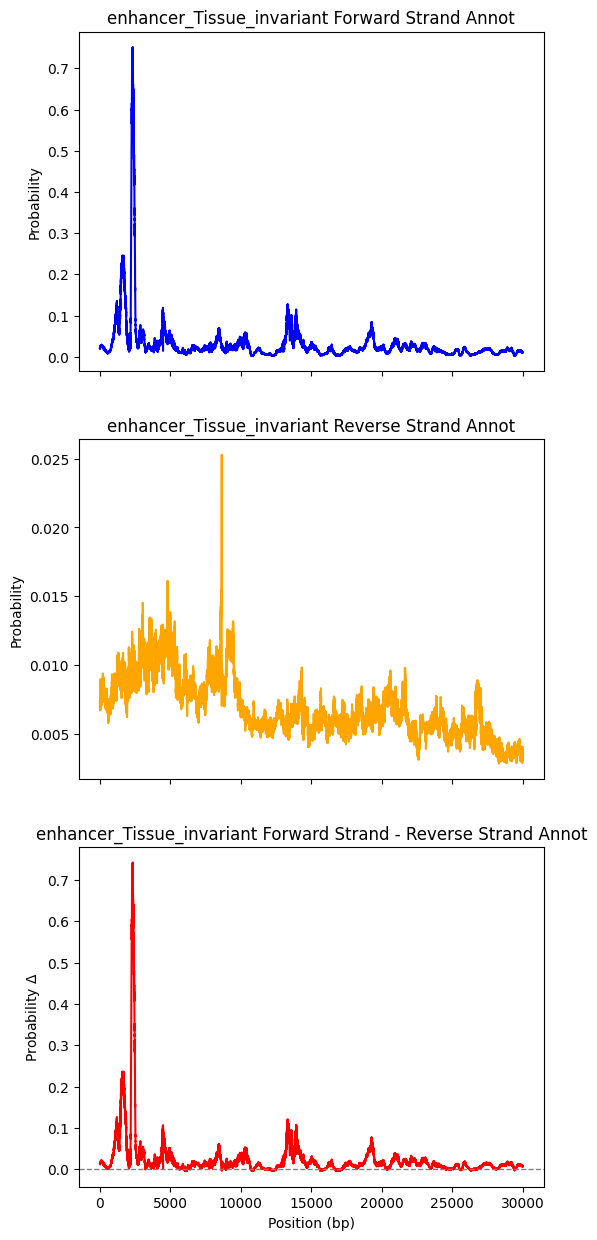

In [24]:
annot_idx = 11
fig, axes = plt.subplots(3, 1, figsize=(6, 15), sharex=True)  # 3 rows, 1 column

axes[0].plot(np.arange(window_size), base_probs[idx:idx+window_size,annot_idx], label='+ strand', color='blue')
axes[0].set_title(f'{annotations[annot_idx]} Forward Strand Annot')
axes[0].set_ylabel('Probability')
axes[1].plot(np.arange(window_size), rc_base_probs[idx:idx+window_size,annot_idx], label='- strand', color='orange')
axes[1].set_title(f'{annotations[annot_idx]} Reverse Strand Annot')
axes[1].set_ylabel('Probability')
axes[2].plot(np.arange(window_size), base_probs[idx:idx+window_size,annot_idx] - rc_base_probs[idx:idx+window_size,annot_idx], label='fwd - rev', color='red')
axes[2].axhline(y=0, color='gray', linestyle='--', linewidth=1, label='y=0')  # Dashed horizontal line
axes[2].set_title(f'{annotations[annot_idx]} Forward Strand - Reverse Strand Annot')
axes[2].set_ylabel('Probability $\Delta$')
axes[2].set_xlabel('Position (bp)')

<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_3136185/3775120387.py:13: SyntaxWarning: invalid escape sequence '\D'
  axes[2].set_ylabel('Probability $\Delta$')


Text(0.5, 0, 'Position (bp)')

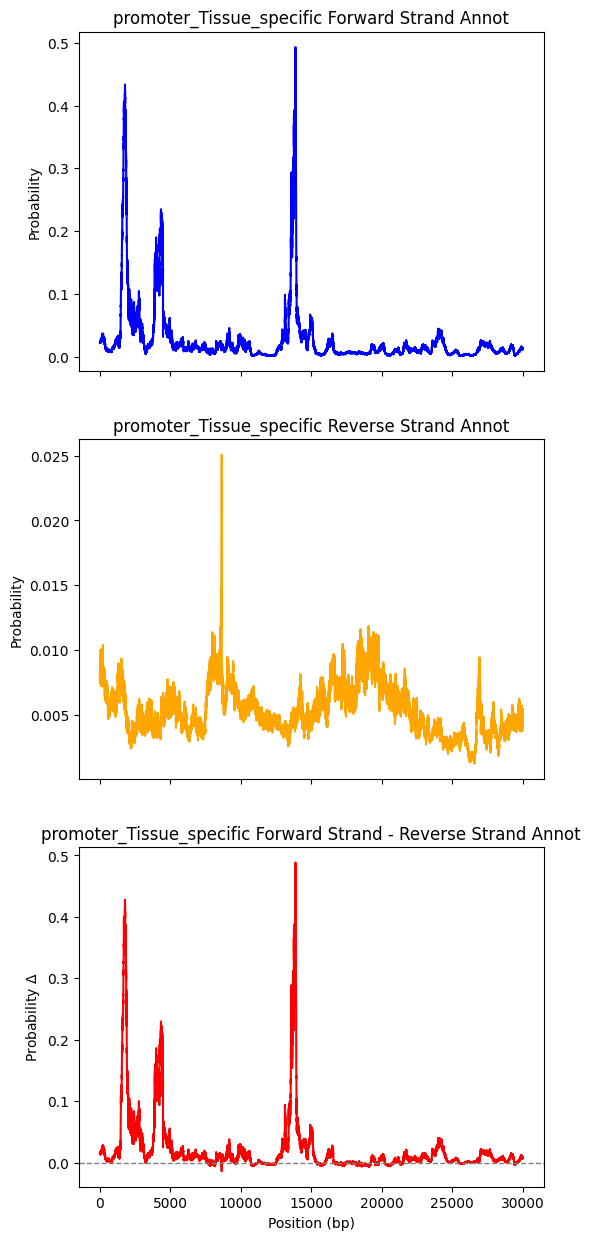

In [25]:
annot_idx = 12
fig, axes = plt.subplots(3, 1, figsize=(6, 15), sharex=True)  # 3 rows, 1 column

axes[0].plot(np.arange(window_size), base_probs[idx:idx+window_size,annot_idx], label='+ strand', color='blue')
axes[0].set_title(f'{annotations[annot_idx]} Forward Strand Annot')
axes[0].set_ylabel('Probability')
axes[1].plot(np.arange(window_size), rc_base_probs[idx:idx+window_size,annot_idx], label='- strand', color='orange')
axes[1].set_title(f'{annotations[annot_idx]} Reverse Strand Annot')
axes[1].set_ylabel('Probability')
axes[2].plot(np.arange(window_size), base_probs[idx:idx+window_size,annot_idx] - rc_base_probs[idx:idx+window_size,annot_idx], label='fwd - rev', color='red')
axes[2].axhline(y=0, color='gray', linestyle='--', linewidth=1, label='y=0')  # Dashed horizontal line
axes[2].set_title(f'{annotations[annot_idx]} Forward Strand - Reverse Strand Annot')
axes[2].set_ylabel('Probability $\Delta$')
axes[2].set_xlabel('Position (bp)')

<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_3136185/2728927443.py:13: SyntaxWarning: invalid escape sequence '\D'
  axes[2].set_ylabel('Probability $\Delta$')


Text(0.5, 0, 'Position (bp)')

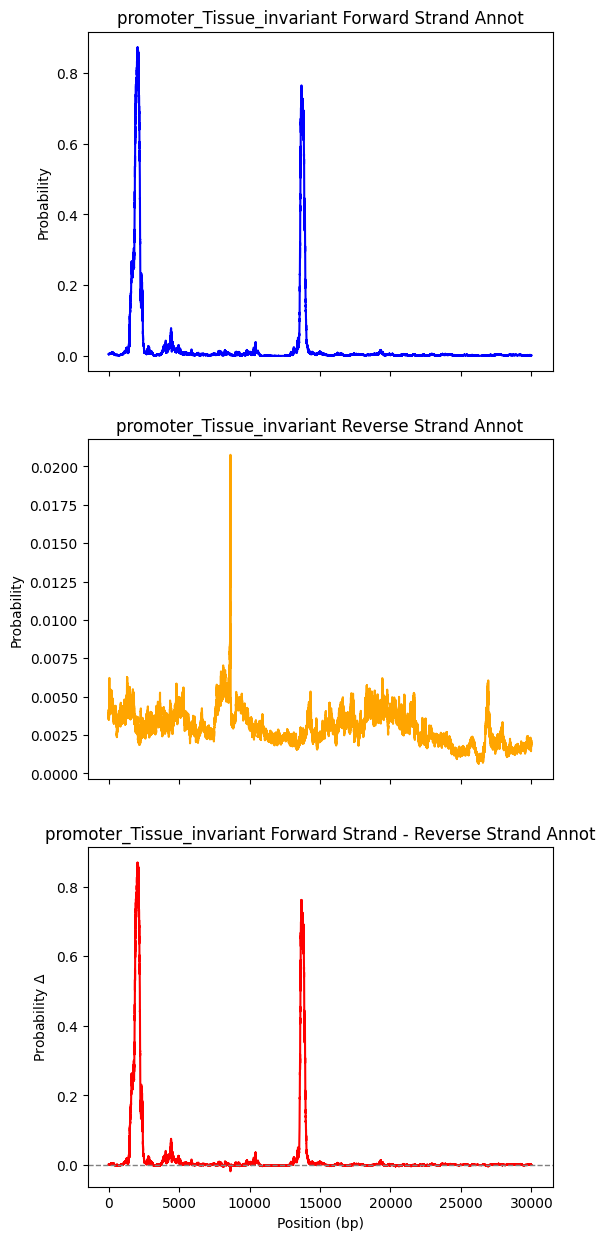

In [26]:
annot_idx = 13
fig, axes = plt.subplots(3, 1, figsize=(6, 15), sharex=True)  # 3 rows, 1 column

axes[0].plot(np.arange(window_size), base_probs[idx:idx+window_size,annot_idx], label='+ strand', color='blue')
axes[0].set_title(f'{annotations[annot_idx]} Forward Strand Annot')
axes[0].set_ylabel('Probability')
axes[1].plot(np.arange(window_size), rc_base_probs[idx:idx+window_size,annot_idx], label='- strand', color='orange')
axes[1].set_title(f'{annotations[annot_idx]} Reverse Strand Annot')
axes[1].set_ylabel('Probability')
axes[2].plot(np.arange(window_size), base_probs[idx:idx+window_size,annot_idx] - rc_base_probs[idx:idx+window_size,annot_idx], label='fwd - rev', color='red')
axes[2].axhline(y=0, color='gray', linestyle='--', linewidth=1, label='y=0')  # Dashed horizontal line
axes[2].set_title(f'{annotations[annot_idx]} Forward Strand - Reverse Strand Annot')
axes[2].set_ylabel('Probability $\Delta$')
axes[2].set_xlabel('Position (bp)')

# Load DNA sequence
Pair the annotations with their assocated DNA sequence

In [10]:
from Bio import SeqIO

In [11]:
chr20 = next(SeqIO.parse('data/human/Homo_sapiens.GRCh38.dna.chromosome.20.fa', 'fasta'))

In [12]:
rc_chr20_sequence = chr20.reverse_complement().seq[::-1]
chr20_sequence = chr20.seq

In [13]:
print(chr20_sequence[idx:idx+200])
print(rc_chr20_sequence[idx:idx+200])

NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


# Process Splice Sites
Assuming we only care about splice sites, we can process out just the splice sites along 

In [14]:
splice_acceptor_idx = annotations.index('splice_acceptor')
splice_donor_idx = annotations.index('splice_donor')

splice_acceptor_annotations = base_probs[:, splice_acceptor_idx]
rc_splice_acceptor_annotations = rc_base_probs[:, splice_acceptor_idx]
splice_donor_annotations = base_probs[:, splice_donor_idx]
rc_splice_donor_annotations = rc_base_probs[:, splice_donor_idx]

<Axes: >

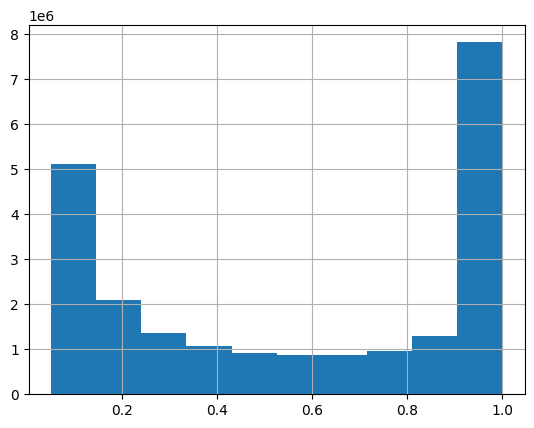

In [34]:
pd.Series(rc_splice_acceptor_annotations[rc_splice_acceptor_annotations>0.05]).hist()

In [44]:
min_thresh = 0.80
window_size = 21 #base pairs to select around the passed threshold
pass_locations = splice_acceptor_annotations > min_thresh
print(f"{pass_locations.sum()} bps ({pass_locations.sum()*100/splice_acceptor_annotations.shape[0]} %) passed threshold of {min_thresh}")
indices = np.arange(pass_locations.shape[0])
passed_indices = indices[pass_locations]
acceptor_rows = []
for passed_idx in tqdm(passed_indices):
    annotation_prob = splice_acceptor_annotations[passed_idx-(window_size//2):passed_idx+(window_size//2)]
    dna_seq = chr20_sequence[passed_idx-(window_size//2):passed_idx+(window_size//2)]
    row_dict = {
        'seqid': f'chr20:{passed_idx}',
        'source': 'segment_nt',
        'type': 'splice_site_acceptor',
        'start': passed_idx-(window_size//2),
        'end': passed_idx+(window_size//2),
        'score': splice_acceptor_annotations[passed_idx],
        'strand': '+', 
        'phase': ".",
        'attributes': f'window_sequence:{dna_seq}'
    }
    acceptor_rows.append(row_dict)


3375 bps (0.005237091512099148 %) passed threshold of 0.8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3375/3375 [00:00<00:00, 259662.78it/s]


In [45]:
rc_pass_locations = rc_splice_acceptor_annotations > min_thresh
print(f"{rc_pass_locations.sum()} bps ({rc_pass_locations.sum()*100/rc_splice_acceptor_annotations.shape[0]} %) passed threshold of {min_thresh}")
rc_indices = np.arange(rc_pass_locations.shape[0])
rc_passed_indices = rc_indices[rc_pass_locations]
for passed_idx in tqdm(rc_passed_indices):
    rc_annotation_prob = rc_splice_acceptor_annotations[passed_idx-(window_size//2):passed_idx+(window_size//2)]
    dna_seq = rc_chr20_sequence[passed_idx-(window_size//2):passed_idx+(window_size//2)]
    row_dict = {
        'seqid': f'chr20:{passed_idx}',
        'source': 'segment_nt',
        'type': 'splice_site_acceptor',
        'start': passed_idx-(window_size//2),
        'end': passed_idx+(window_size//2),
        'score': rc_splice_acceptor_annotations[passed_idx],
        'strand': '-', 
        'phase': ".",
        'attributes': f'window_sequence:{dna_seq}'
    }
    acceptor_rows.append(row_dict)


9220600 bps (14.307889184136712 %) passed threshold of 0.8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9220600/9220600 [00:28<00:00, 319576.74it/s]


In [46]:
acceptor_df = pd.DataFrame(acceptor_rows)

In [47]:
min_thresh = min_thresh
window_size = window_size #base pairs to select around the passed threshold
pass_locations = splice_donor_annotations > min_thresh
print(f"{pass_locations.sum()} bps ({pass_locations.sum()*100/splice_donor_annotations.shape[0]} %) passed threshold of {min_thresh}")
indices = np.arange(pass_locations.shape[0])
passed_indices = indices[pass_locations]
donor_rows = []
for passed_idx in tqdm(passed_indices):
    annotation_prob = splice_donor_annotations[passed_idx-(window_size//2):passed_idx+(window_size//2)]
    dna_seq = chr20_sequence[passed_idx-(window_size//2):passed_idx+(window_size//2)]
    row_dict = {
        'seqid': f'chr20:{passed_idx}',
        'source': 'segment_nt',
        'type': 'splice_site_donor',
        'start': passed_idx-(window_size//2),
        'end': passed_idx+(window_size//2),
        'score': splice_donor_annotations[passed_idx],
        'strand': '+', 
        'phase': ".",
        'attributes': f'window_sequence:{dna_seq}'
    }
    donor_rows.append(row_dict)

3638 bps (0.0056451967173382816 %) passed threshold of 0.8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3638/3638 [00:00<00:00, 267366.58it/s]


In [48]:
rc_pass_locations = rc_splice_donor_annotations > min_thresh
print(f"{rc_pass_locations.sum()} bps ({rc_pass_locations.sum()*100/rc_splice_donor_annotations.shape[0]} %) passed threshold of {min_thresh}")
rc_indices = np.arange(rc_pass_locations.shape[0])
rc_passed_indices = rc_indices[rc_pass_locations]
for passed_idx in tqdm(rc_passed_indices):
    rc_annotation_prob = rc_splice_donor_annotations[passed_idx-(window_size//2):passed_idx+(window_size//2)]
    dna_seq = rc_chr20_sequence[passed_idx-(window_size//2):passed_idx+(window_size//2)]
    row_dict = {
        'seqid': f'chr20:{passed_idx}',
        'source': 'segment_nt',
        'type': 'splice_site_donor',
        'start': passed_idx-(window_size//2),
        'end': passed_idx+(window_size//2),
        'score': rc_splice_donor_annotations[passed_idx],
        'strand': '-', 
        'phase': ".",
        'attributes': f'window_sequence:{dna_seq}'
    }
    donor_rows.append(row_dict)


9360881 bps (14.525567535072646 %) passed threshold of 0.8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9360881/9360881 [00:27<00:00, 336240.71it/s]


In [49]:
donor_df = pd.DataFrame(donor_rows)

In [50]:
joined_df = pd.concat([acceptor_df, donor_df]).sort_values(by=['start'])

In [54]:
joined_df

,seqid,source,type,start,end,score,strand,phase,attributes
3375,chr20:124191,segment_nt,splice_site_acceptor,124181,124201,0.844843,-,.,window_sequence:TCCTCCTTCACCGTGTTATA
3376,chr20:124197,segment_nt,splice_site_acceptor,124187,124207,0.823349,-,.,window_sequence:TTCACCGTGTTATAAAAATT
3638,chr20:124199,segment_nt,splice_site_donor,124189,124209,0.858961,-,.,window_sequence:CACCGTGTTATAAAAATTTC
3377,chr20:124233,segment_nt,splice_site_acceptor,124223,124243,0.859873,-,.,window_sequence:CAGAGTTAGGTCTATAGATA
3378,chr20:124239,segment_nt,splice_site_acceptor,124229,124249,0.905308,-,.,window_sequence:TAGGTCTATAGATACAGGTT
...,...,...,...,...,...,...,...,...,...
9223970,chr20:64300862,segment_nt,splice_site_acceptor,64300852,64300872,0.832674,-,.,window_sequence:AACCGTTTGGTATTAACATG
9223971,chr20:64300863,segment_nt,splice_site_acceptor,64300853,64300873,0.816776,-,.,window_sequence:ACCGTTTGGTATTAACATGT
9223972,chr20:64300864,segment_nt,splice_site_acceptor,64300854,64300874,0.881453,-,.,window_sequence:CCGTTTGGTATTAACATGTA
9223973,chr20:64300868,segment_nt,splice_site_acceptor,64300858,64300878,0.864547,-,.,window_sequence:TTGGTATTAACATGTATAAG


In [53]:
joined_df.to_csv(f"segment_nt_splice_sites_{min_thresh}_filter.gff", sep='\t', index=False)

# Convert to Helixer
We can conver the Segment NT outputs into the same output as helixer and therefore use HelixerPOST with it. 

Helixer expects the following annotations:
* Intergenic
* UTR
* CDS
* Intron

Furthermore, Helixer expects these annotations to be mutually exclusive (e.g. softmax over the annotations for each base pair).

Segment-NT outputs 14 tracks (listed above) that are each modeled indepedantly. If we select, and sum the appropriate annotations though, we can then normalize the probabilities at thne end and get an output consistent with Helixer (ignoring the phase output that helixer also expects).

## Mapping
This maps as follows
* (1-protein coding gene) -> Intergenic
* (3UTR + 5UTR) -> UTR
* (Exon) -> CDS
* (Intron) -> Intron

These mappings seem roughly reasonable, the only problem is that they don't define a valid probability distribution like HelixerPost expects, so after the initial mapping like above we should normalize over the attribute dimension. 

The extra phasing matrix is a bit of a pain, but it only really matters for the CDS portions and by default we should be able to replaced it with a uniform over the 3 phases at any place where CDS is the argmax.

## Genome Processing
There is an additional genome processing step where we have to one-hot encode the Genome Sequence that was used to generate the data, but we should be able to pull this directlly from Helixer by saving some of the intermediaries.


In [28]:
protein_coding_annotation_idx = annotations.index('protein_coding_gene')
protein_coding_annotations = base_probs[:, protein_coding_annotation_idx]
intergenic_prob = 1- protein_coding_annotations

In [29]:
three_utr_annotation_idx = annotations.index('3UTR')
three_utr_annotation = base_probs[:, three_utr_annotation_idx]

five_utr_annotation_idx = annotations.index('5UTR')
five_utr_annotation = base_probs[:, five_utr_annotation_idx]

utr_prob = three_utr_annotation + five_utr_annotation # not technically a prob distriubtion, it's the (unnormalized) sum of two probabilties dists

In [30]:
exon_annotation_idx = annotations.index('exon')
exon_prob = base_probs[:, exon_annotation_idx]

In [31]:
intron_annotation_idx = annotations.index('intron')
intron_prob = base_probs[:, intron_annotation_idx]

In [32]:
new_annotations = np.concatenate([intergenic_prob[:, None], utr_prob[:, None], exon_prob[:, None], intron_prob[:, None]], axis=1)
print(new_annotations.shape)

(64444167, 4)


In [90]:
#new_annotations = torch.from_numpy(new_annotations)
#F.softmax(new_annotations,dim=1)

In [33]:
normed_new_annotations = new_annotations/(new_annotations.sum(axis=1)[:, None])

In [34]:
pd.Series(normed_new_annotations.sum(axis=1)).describe()

count    6.444417e+07
mean     1.000000e+00
std      3.584482e-17
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
dtype: float64

In [38]:
normed_new_annotations[idx:idx+300,:]

array([[0.94211295, 0.01393413, 0.02214015, 0.02181276],
       [0.94102197, 0.01385547, 0.02253243, 0.02259013],
       [0.94130494, 0.01377805, 0.02157155, 0.02334546],
       ...,
       [0.03122009, 0.13384984, 0.16153107, 0.67339901],
       [0.03022846, 0.14163561, 0.15298118, 0.67515475],
       [0.03330416, 0.13977742, 0.16133679, 0.66558163]])

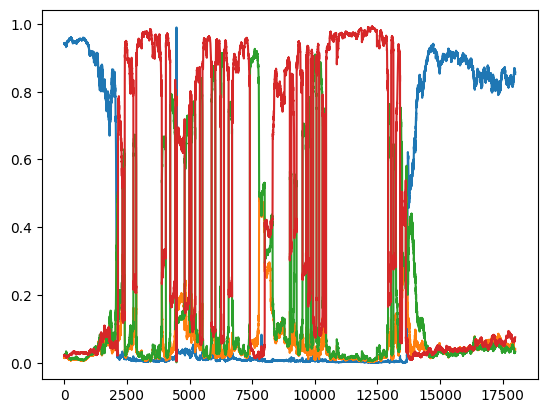

In [47]:
plot_window = 18000
plt.plot(np.arange(plot_window), normed_new_annotations[idx:idx+plot_window,:])